In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .35 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = np.random.normal(1, .05, size=n)
phat0 = g*F0/S0

#holdings fiat
h = sts.expon.rvs( loc=10,scale=10, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

#beta is param for armijo rule
beta = .9

In [4]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'population':[n],
    'beta':[beta],
    'phi': [phi],
    'invariant': [V0]}

In [5]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'action': {}}

In [6]:
initial_conditions

{'action': {},
 'funds': 35000.0,
 'holdings': array([23.8758429 , 19.69422134, 24.04963987, 22.02095349, 10.30212993,
        18.17136723, 11.0043178 , 19.91731541, 11.33560817, 10.09139318,
        17.7053175 , 23.82566017, 10.73375734, 13.65966005, 25.25668118,
        13.64483165, 21.24892853, 15.09909976, 22.12760802, 10.1742936 ,
        32.93410966, 15.60721614, 19.62665191, 14.81617445, 30.7923421 ,
        10.49769916, 11.57350107, 50.82820249, 14.53672601, 20.63413621,
        14.46596895, 27.23749848, 26.18647322, 21.99187696, 26.46082563,
        19.81674324, 10.72164709, 34.54482858, 19.15387341, 11.98270767,
        10.28310962, 31.44593751, 33.26254118, 21.9739018 , 18.14631281,
        22.71897435, 13.78070507, 20.24983316, 41.44776176, 52.27322915,
        11.49594833, 28.15857322, 32.95311975, 14.32106799, 34.07549769,
        11.31316484, 13.10084631, 12.2771365 , 11.65251749, 27.54629303,
        29.87989537, 18.75105406, 13.5188925 , 26.11613234, 21.28990219,
     

In [7]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = 0, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    if delF <1:
        if s['funds'] <1000:
            delF =100
    
    return({'delF':delF})

In [8]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [9]:
def update_prices(params, step, sL, s, _input):
    
    g = params['gains']
    phat = g*s['funds']/s['supply']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [10]:
#change in F (revenue and spending accounted for)
def choose_agent(params, step, sL, s):
    n = params['population']
    rv = np.random.randint(0,n)
    return({'agent':rv})

In [11]:
def agent_action(params, step, sL, s, _input):
    
    a = _input['agent']
    h_a = s['holdings'][a]
    phat_a = s['prices'][a]
    s_a =  s['tokens'][a]
    p = s['spot_price']
    
    beta = params['beta']
    
    if p>phat_a: #equiv: pbar(0)>phat_a
        mech = 'burn'
        #approx for burn s.t. p=phat
        #armijo style
        amt = s_a
        
        def pbar(amt):
            output = withdraw_with_tax(amt, s['reserve'],s['supply'], params['invariant'], params['phi'], params['kappa'])
            
            if not(output[2])>0:
                return np.Infinity
            else:
                return output[2]
        
        
        while pbar(amt)< phat_a:
            amt = amt*beta
        
    else: # p<phat_a; #equiv pbar(0)<phat_a
        mech = 'bond'
        #approx for buy s.t. p=phat
        #armijo style
        amt = h_a
        
        def pbar(amt):
            output = mint(amt, s['reserve'],s['supply'], params['invariant'], params['kappa'])
            
            if not(output[1])>0:
                return 0
            else:
                return output[1]
        
        while pbar(amt)> phat_a:
            amt = amt*beta
    
    #print(mech)
    #print(amt)
    #print(pbar(amt))
    key = 'action'
    value = {'agent':a, 'mech':mech, 'amt':amt, 'pbar':pbar(amt)}
    
    return (key, value)

In [12]:
def resolve_action(params, step, sL, s):
    action = s['action']
    a = action['agent']
    amt = action['amt']
    h_a = s['holdings'][a]
    s_a =  s['tokens'][a]
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    
    if action['mech'] == 'bond':
        h_a = h_a-amt
        dS, pbar = mint(amt, R,S, V0, params['kappa'])
        R = R+amt
        S = S+dS
        s_a = s_a+dS
        P = spot_price(R, V0, kappa)
    
    elif action['mech'] == 'burn':
        s_a = s_a-amt
        dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
        R = R-dR
        F = F + params['phi']*dR
        S = S-amt
        h_a = h_a + (1-params['phi'])*dR
        P = spot_price(R, V0, kappa)
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a})

In [13]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    h_a = _input['h_a']
    a = _input['a']
    
    h = s['holdings']
    h[a] = h_a
    
    key = 'holdings'
    value = h
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    s_a = _input['s_a']
    a = _input['a']
    
    tokens = s['tokens']
    tokens[a] = s_a
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [14]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agent
        },
        'variables': { 
            'action': agent_action, 
        }
    },
    {
      'policies': {
          'act': resolve_action,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [15]:
time_periods_per_run = 300
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [16]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 300), 'M': {'kappa': 2, 'lambda': 200, 'gains': array([0.99147412, 1.00022973, 1.06476773, 0.95561498, 0.91801408,
       1.00734382, 1.01135583, 1.06041933, 1.05509357, 0.94456693,
       0.99497888, 0.9642258 , 0.96708019, 0.99921331, 1.01899485,
       1.03142817, 0.98211835, 0.97903723, 1.05878192, 0.93588367,
       0.99939403, 0.9877718 , 0.96955855, 0.98352141, 0.90254589,
       1.00236469, 1.06911097, 0.97621233, 1.00671504, 0.93209234,
       1.00202922, 1.03321211, 1.02432448, 1.02095369, 0.97163898,
       0.98428338, 0.98921774, 0.98643192, 0.98860959, 0.99905631,
       0.97167925, 1.00456465, 0.99046072, 0.96190988, 1.04424163,
       0.93002334, 1.00337459, 1.02458094, 1.00561722, 0.95269826,
       1.07126847, 0.94102154, 1.08037467, 1.02329009, 1.00266749,
       0.97887202, 0.97058923, 0.96914434, 0.95365847, 0.97648692,
       1.00717438, 1.02822531, 1.02212882, 1.00420173, 1.01417108,
       0.95308863, 0.95110406, 0.92644275, 0.97184703, 1.

In [17]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [18]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a0ea792e8>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a0ea792e8>]


/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS


In [19]:
experiment_index = 0
df = results[experiment_index]['result']

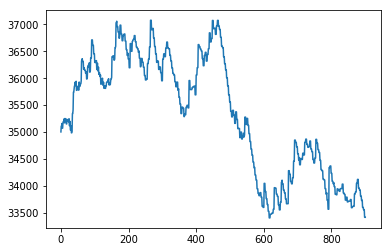

In [20]:
df.funds.plot()

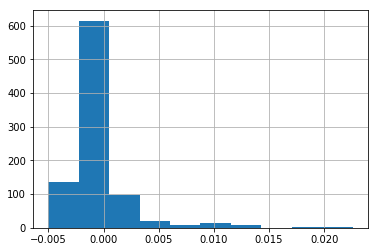

In [21]:
(df.funds.diff()/df.funds).hist()

In [22]:
rdf = df[df.substep == 3].copy()

In [23]:
rdf['token_wts'] = (rdf.tokens/rdf.supply)
rdf['wt_mean_price'] = (rdf.token_wts*rdf.prices).apply(sum)

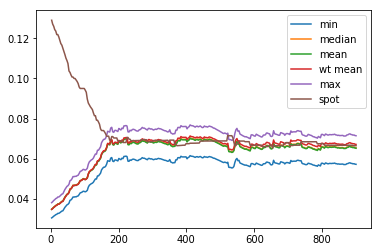

In [24]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','wt mean','max', 'spot'])

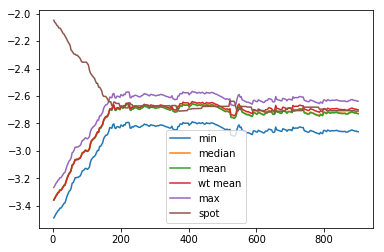

In [25]:
rdf.prices.apply(np.min).apply(np.log).plot()
rdf.prices.apply(np.median).apply(np.log).plot()
rdf.prices.apply(np.mean).apply(np.log).plot()
rdf.wt_mean_price.apply(np.log).plot()
rdf.prices.apply(np.max).apply(np.log).plot()
rdf.spot_price.apply(np.log).plot()
plt.legend(['min', 'median','mean','wt mean','max', 'spot'])

In [26]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

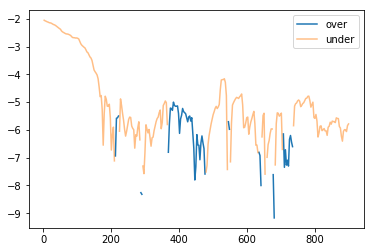

In [27]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [28]:
rdf['est_err'] = rdf.spot_price - rdf.wt_mean_price
rdf['sq_est_err'] = rdf['est_err']**2

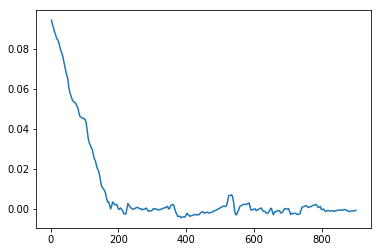

In [29]:
rdf.est_err.plot()

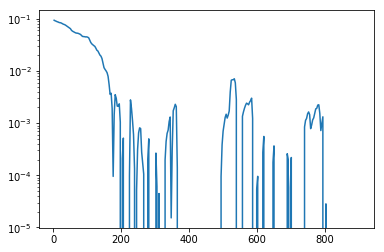

In [30]:
rdf.est_err.plot(logy=True)

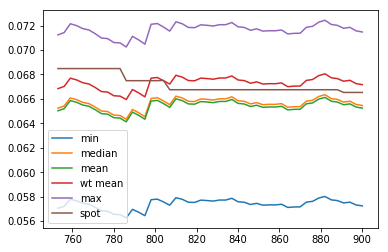

In [31]:
#tail T
T = 50
rdf.tail(T).prices.apply(np.min).plot()
rdf.tail(T).prices.apply(np.median).plot()
rdf.tail(T).prices.apply(np.mean).plot()
rdf.tail(T).wt_mean_price.plot()
rdf.tail(T).prices.apply(np.max).plot()
rdf.tail(T).spot_price.plot()
plt.legend(['min', 'median','mean','wt mean','max', 'spot'])

In [32]:
bond_amts = [rdf.iloc[k].action['amt'] for k in range(time_periods_per_run) if rdf.iloc[k].action['mech']=='bond']
burn_amts = [rdf.iloc[k].action['amt'] for k in range(time_periods_per_run) if rdf.iloc[k].action['mech']=='burn']

(array([66.,  4.,  2.,  4.,  2.,  1.,  1.,  0.,  1.,  1.]),
 array([   0.        ,  150.0450635 ,  300.09012699,  450.13519049,
         600.18025398,  750.22531748,  900.27038098, 1050.31544447,
        1200.36050797, 1350.40557147, 1500.45063496]),
 <a list of 10 Patch objects>)

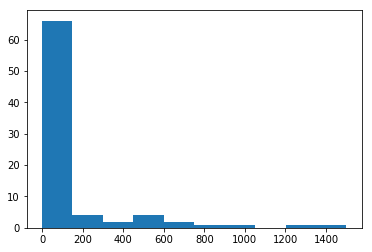

In [33]:
plt.hist(bond_amts)

(array([155.,  10.,  22.,   6.,  16.,   5.,   2.,   0.,   0.,   2.]),
 array([    0.        ,  2859.44265575,  5718.88531149,  8578.32796724,
        11437.77062299, 14297.21327873, 17156.65593448, 20016.09859022,
        22875.54124597, 25734.98390172, 28594.42655746]),
 <a list of 10 Patch objects>)

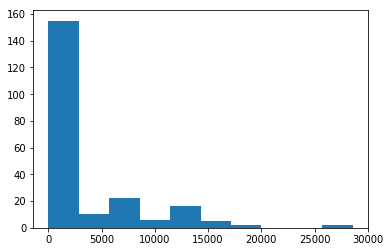

In [34]:
plt.hist(burn_amts)

In [35]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

In [36]:
rdf['resid'] = rdf.invariant-V0

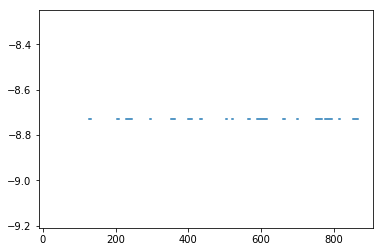

In [37]:
rdf.resid.apply(np.log10).plot()

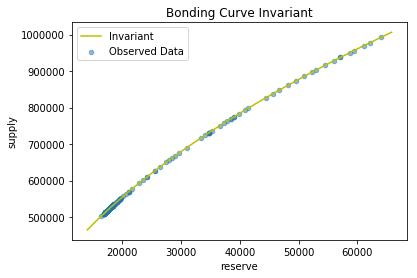

In [38]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

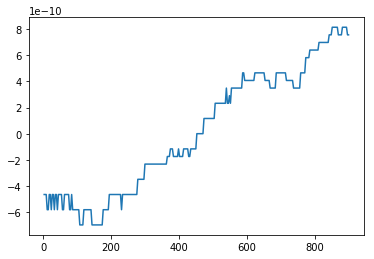

In [39]:
(rdf.tokens.apply(sum)-rdf.supply).plot()

In [40]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [41]:
rdf['gini_h'] = rdf.holdings.apply(gini)

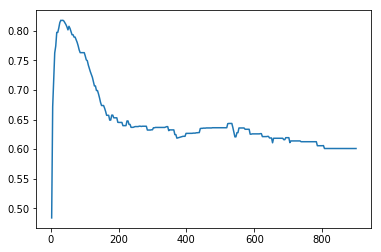

In [42]:
rdf.gini_h.plot()

In [43]:
rdf['gini_s'] = rdf.tokens.apply(gini)

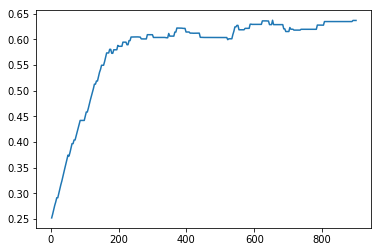

In [44]:
rdf.gini_s.plot()

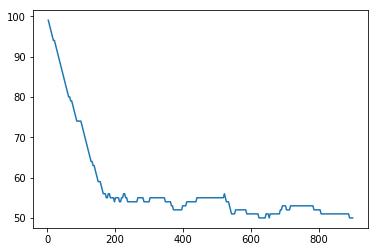

In [45]:
rdf.tokens.apply(np.count_nonzero).plot()

In [46]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [47]:
rdf['gini'] = rdf.asset_value.apply(gini)

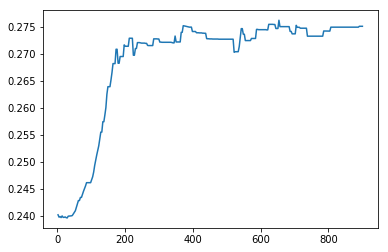

In [48]:
rdf.gini.plot()

In [49]:
rdf.tokens.sum()

array([3040526.00591377,  292346.41324499, 1834911.75066471,
        191306.33867813, 2676437.18439034,  606503.89825269,
       1913536.35613044,  202520.81288736, 1757170.10210485,
        942629.03361786, 2146360.00963785, 1164235.6179812 ,
        525138.6253403 ,  405352.79043558, 3688078.31557373,
        358923.57068847,  837417.24115256, 6982141.0341338 ,
       2815214.29691066,  268158.49992348, 3070289.7371441 ,
       4588261.10103541,   38629.38518291, 1989622.13358692,
        133316.07055125, 1624043.9233252 , 6104295.96660485,
        123352.79808506, 1863959.91612605,  476647.34132436,
       1954128.81816917, 1493642.7972997 , 1764743.65166815,
       4801389.36574534,  329201.81578263,  220463.52809205,
        873172.3654704 ,  294140.49567193, 2819621.45423573,
       2377205.52335175, 2330992.21389353, 1833572.86993064,
        269770.50349571,  956149.43352349, 2280230.16892458,
       2287475.15948303, 2315509.59142972, 3441584.33213069,
       1621235.29017322,